# Problem Description

- COVID-19 brought the airline industry to a screeching halt. The average profit for airlines company was down by almost 50% (Bouwer et al., 2022) when most countries closed down their borders to international travellers. In an industry that operates on razor-thin margins, a huge cutdown on profits like this is potentially lethal for an airline.
- After 1.5 to 2 years of lockdowns, the tourism industry started seeing some upswings in the number of travellers across interational airports. Since most airport & airlines furloughed a vast majority of their staff during peak COVID times as a cost-cutting measure, it was hard to bring everyone back & ready to work before the peak of travelling boom.
- Over the last few months, almost every airline has either delayed a flight by a few hours or outright cancelled a flight due to lack of available personnel (Bergeron-Oliver & Lee, 2022).
- Frustrated customers have taken to social media to vent their frustrations.
- **Hypothetical Scenario**: The marketing teams across all major US airlines are actively looking for solutions to monitor their PR health status, especially on Twitter. 
- **Problem**: Create a deep learning model that can identify the sentiments of the user (positive or negative) from a tweet.
- The data for this problem has been sourced from Kaggle published by Figure Eight (Figure Eight, 2019). 
- Link to this project's Github repository: https://github.com/karansangha/5511_week6_finalproject

**Data Description**
- The dataset has a little over 14.6k tweets
- The dataset has following features
    1. **tweet_id**: unique id for each tweet
    2. **airline_sentiment**:  a pre-determined label for the tweet (neutral, positive or negative)
    3. **airline_sentiment_confidence**: the confidence level for the assigned sentiment value
    4. **negativereason**: the identifed negative reason for the tweet (bad customer service, etc)
    5. **negativereason_confidence**: the confidence level for the assigned negative reason
    6. **airline**:  the airline company that was tagged in the tweet
    7. **airline_sentiment_gold**: unsure what this means but it's `null` for 100% of the rows so it can be safely excluded 
    8. **name**:  username of the tweeter
    9. **negativereason_gold**: unsure what this means but it's `null` for 100% of the rows so it can be safely excluded
    10. **retweet_count**:  number of retweets the tweet received
    11. **text**:  text contents of the tweet
    12. **tweet_coord**:  latitude & longitde values from where the tweet was generated
    13. **tweet_created**:  the exact date & time the tweet was generated
    14. **tweet_location**:  location from which the tweet was generated
    15. **user_timezone**:  timezone from which the tweet was generated


**References**
- Bergeron-Oliver, A., &amp; Lee, M. (2022, June 29). More than half of flights at some Canadian airports getting cancelled, delayed: Data. CTVNews. Retrieved October 9, 2022, from https://www.ctvnews.ca/politics/more-than-half-of-flights-at-some-canadian-airports-getting-cancelled-delayed-data-1.5967481 
- Bouwer, J., Krishnan, V., Saxon, S., &amp; Tufft, C. (2022, April 1). Taking stock of the pandemic's impact on Global Aviation. McKinsey &amp; Company. Retrieved October 9, 2022, from https://www.mckinsey.com/industries/travel-logistics-and-infrastructure/our-insights/taking-stock-of-the-pandemics-impact-on-global-aviation 

# Exploratory Data Analysis

In [53]:
import numpy as np 
import pandas as pd 
import os
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
df = pd.read_csv("tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### Distribution of airline sentiments

<AxesSubplot: xlabel='airline_sentiment', ylabel='count'>

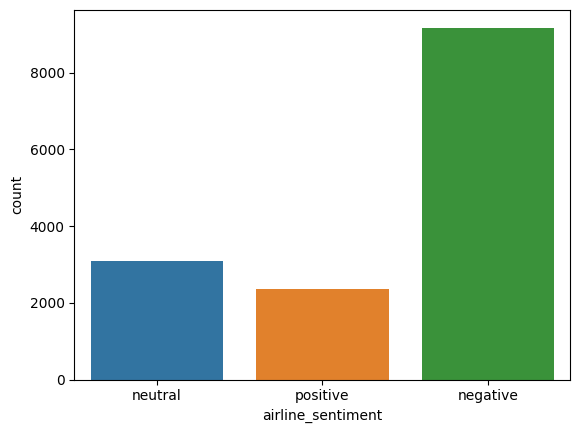

In [5]:
sns.countplot(x="airline_sentiment", data=df)

In [44]:
df["airline_sentiment"].value_counts().index

Index(['negative', 'neutral', 'positive'], dtype='object')

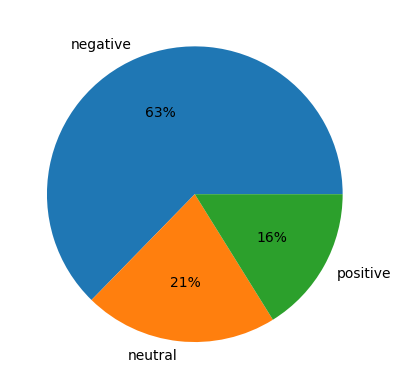

In [45]:
plt.pie(df["airline_sentiment"].value_counts()
        , labels=df["airline_sentiment"].value_counts().index
        , autopct='%.0f%%')
plt.show()

- 63% of the tweets in this dataset are marked `negative`

### Distribution of airline companies

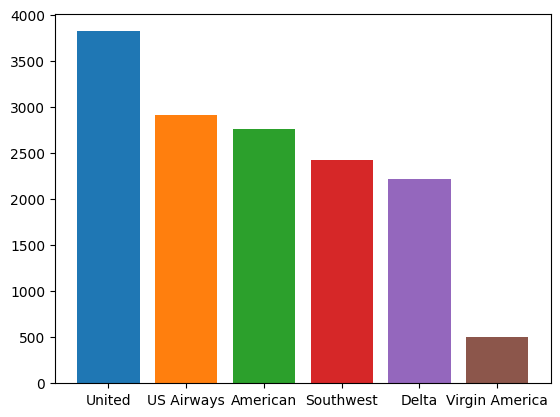

In [85]:
plt.bar(df["airline"].value_counts().index, 
        df["airline"].value_counts(), 
        color=mcolors.TABLEAU_COLORS)
plt.show()

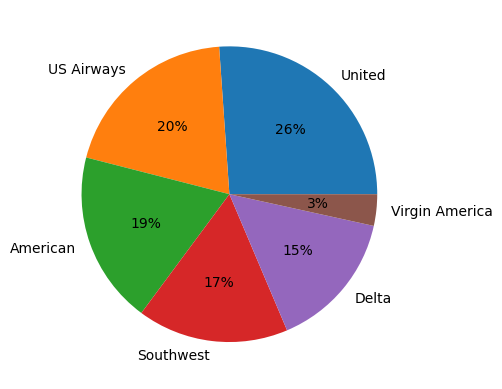

In [47]:
plt.pie(df["airline"].value_counts()
        , labels=df["airline"].value_counts().index
        , autopct='%.0f%%')
plt.show()

### Distribution of sentiments grouped by airline

In [63]:
df.groupby('airline')['airline_sentiment'].value_counts().unstack()

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


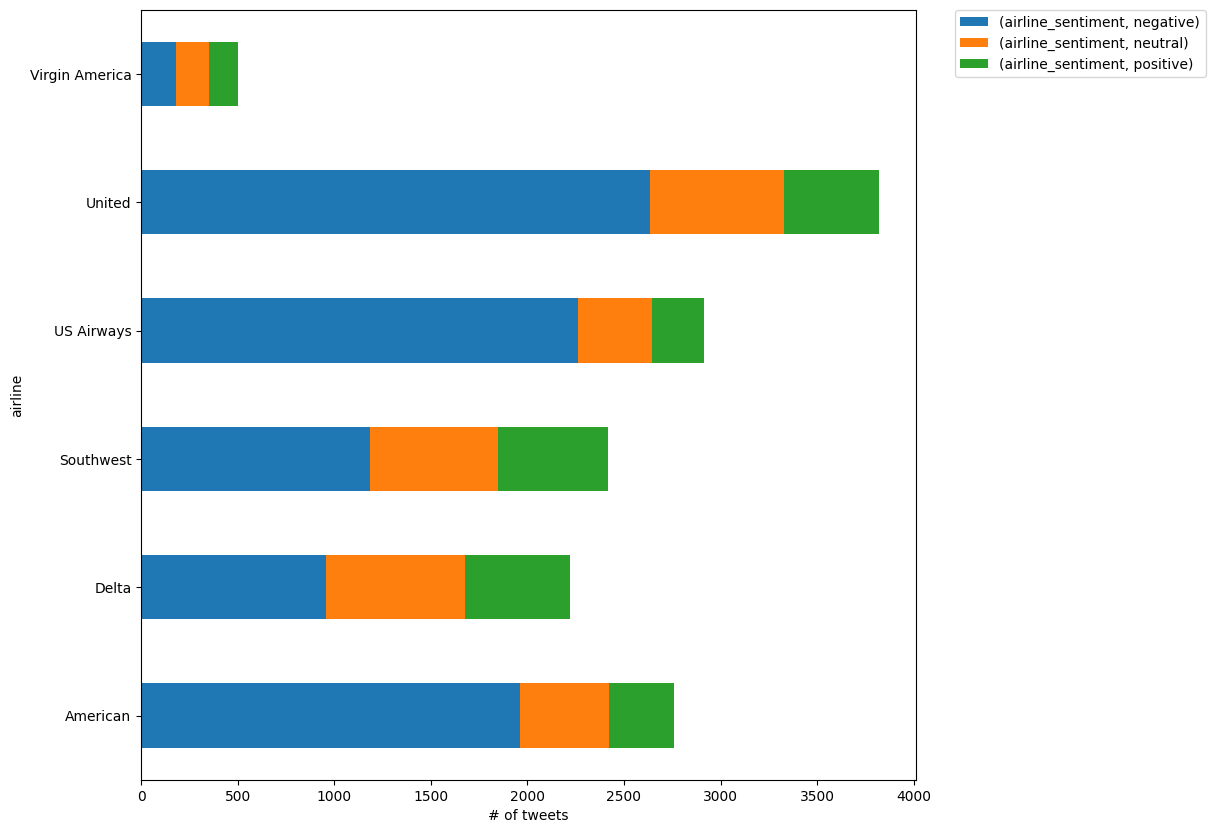

In [86]:
pd.DataFrame(df.groupby('airline')['airline_sentiment'].value_counts()).unstack().plot.barh(figsize=(10,10),stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.xlabel("# of tweets")
plt.show()

- Virgin America receives equal proportion of sentiments in their tweets
- United received a lot more tweets but they also received an overwhelming proportion of negative tweets

### Most common words across each sentiment

In [67]:
from wordcloud import WordCloud, STOPWORDS

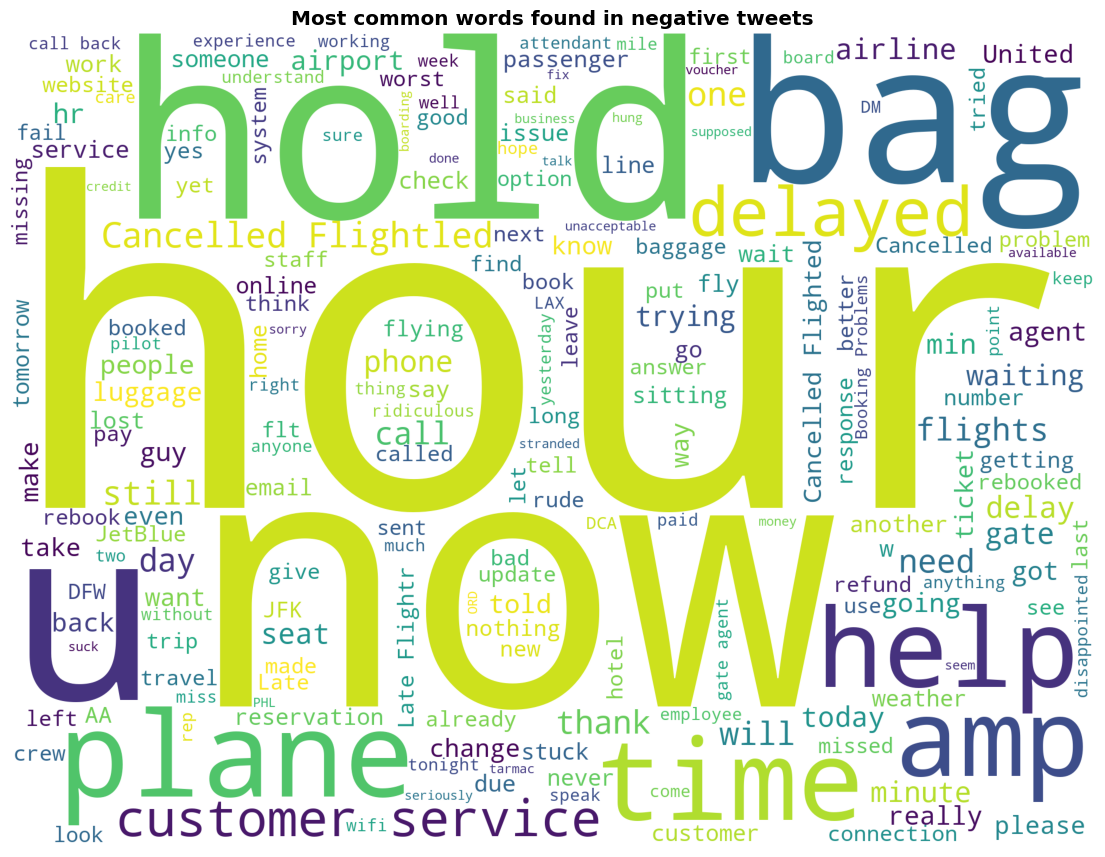

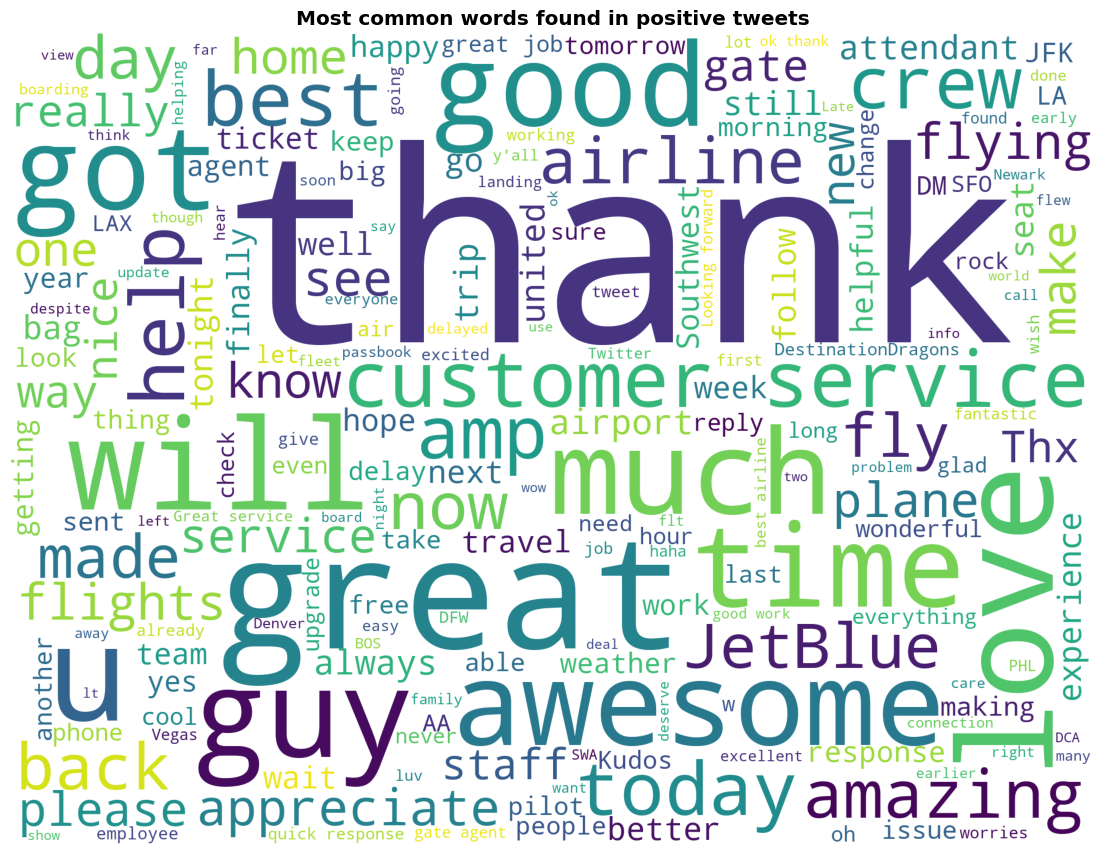

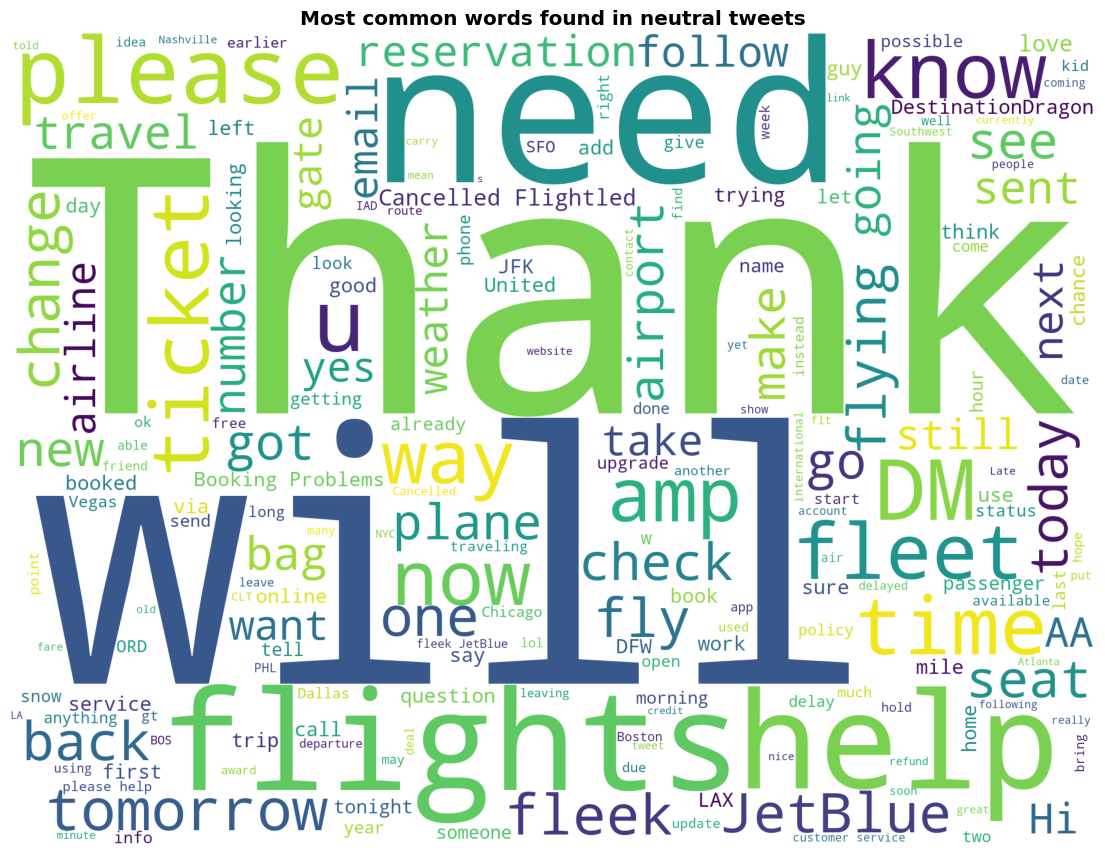

In [83]:
for sentiment in ['negative', 'positive', 'neutral']:
    new_df=df[df['airline_sentiment']==sentiment]
    words = ' '.join(new_df['text'])
    cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])
    wordcloud = WordCloud(stopwords=list(STOPWORDS) + ['flight'],
                          background_color='white',
                          width=2000,
                          height=1500
                         ).generate(cleaned_word)
    plt.figure(1,figsize=(14, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Most common words found in {sentiment} tweets', 
              fontsize="x-large",
              fontweight="bold"
             )
    plt.show()
    print('\n\n')

- As expected, negative tweets frequently mention words like 'customer service', 'time', 'bag'
- Whereas, positive tweets often mention words such as 'thank', 'appreciate', 'great'

## Data Preprocessing

- From the 15 fields available in the dataset, 

# Model Architecture

## Hyperparameter Tuning

# Results

# Conclusion